In [1]:
import glob
import os
import numpy as np
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

In [115]:
def plot_3d_trajectories(demos, repro=None):
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection="3d")
    if repro is None:
        for i in range(demos.shape[0]):
            x_val = demos[i, :, 0]
            y_val = demos[i, :, 1]
            z_val = demos[i, :, 2]
            ax.scatter(x_val, y_val, z_val, s=10)
    else:
        ax.scatter(demos[:, 0], demos[:, 1], demos[:, 2], alpha=0.5, s=1, label="Demonstration")
        ax.scatter(repro[:, 0], repro[:, 1], repro[:, 2], s=5, label="Reproduction")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [136]:
class DynSysDataset(Dataset):
    def __init__(self, skill, train=True, state_type='joint', demos_dir='/work/dlclarge1/lagandua-refine-skills/calvin_demos/'):
        self.skill = skill
        self.demos_dir = demos_dir
        if train:
            fname = 'training'
        else:
            fname = 'validation'
        data_file = glob.glob(os.path.join(self.demos_dir, self.skill, f'{fname}.npy'))[0]
        self.state_type = state_type

        dt = 2 / 30
        start_idx, end_idx = self.get_valid_columns()
        self.X = np.load(data_file)[:,:,start_idx:end_idx]
        self.dX = (self.X[:, 2:, :] - self.X[:, :-2, :]) / dt
        self.X = self.X[:, 1:-1, :]

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.dX[idx]
    
    def get_valid_columns(self):
        if 'joint' in self.state_type:
            start, end = 8, 15
        elif 'pos_ori' in self.state_type:
            start, end = 1, 7
        elif 'pos' in self.state_type:
            start, end = 1, 4
        elif 'ori' in self.state_type:
            start, end = 4, 7
        elif 'grip' in self.state_type:
            start, end = 7, 8
        return start, end
    
    def plot_random(self):
        sampled_path = []
        rand_idx = np.random.randint(0, len(self.X))
        true_x = self.X[rand_idx, :, :]
        x = true_x
        sampling_dt = 1 / 30
        for t in range(62):
            sampled_path.append(x)
            x_dot = self.dX[rand_idx, t, :]
            x = x + sampling_dt * x_dot
        sampled_path = np.array(sampled_path)
        plot_3d_trajectories(true_x, sampled_path)

In [143]:
ds_dataset = DynSysDataset(skill='open_drawer', state_type='pos')

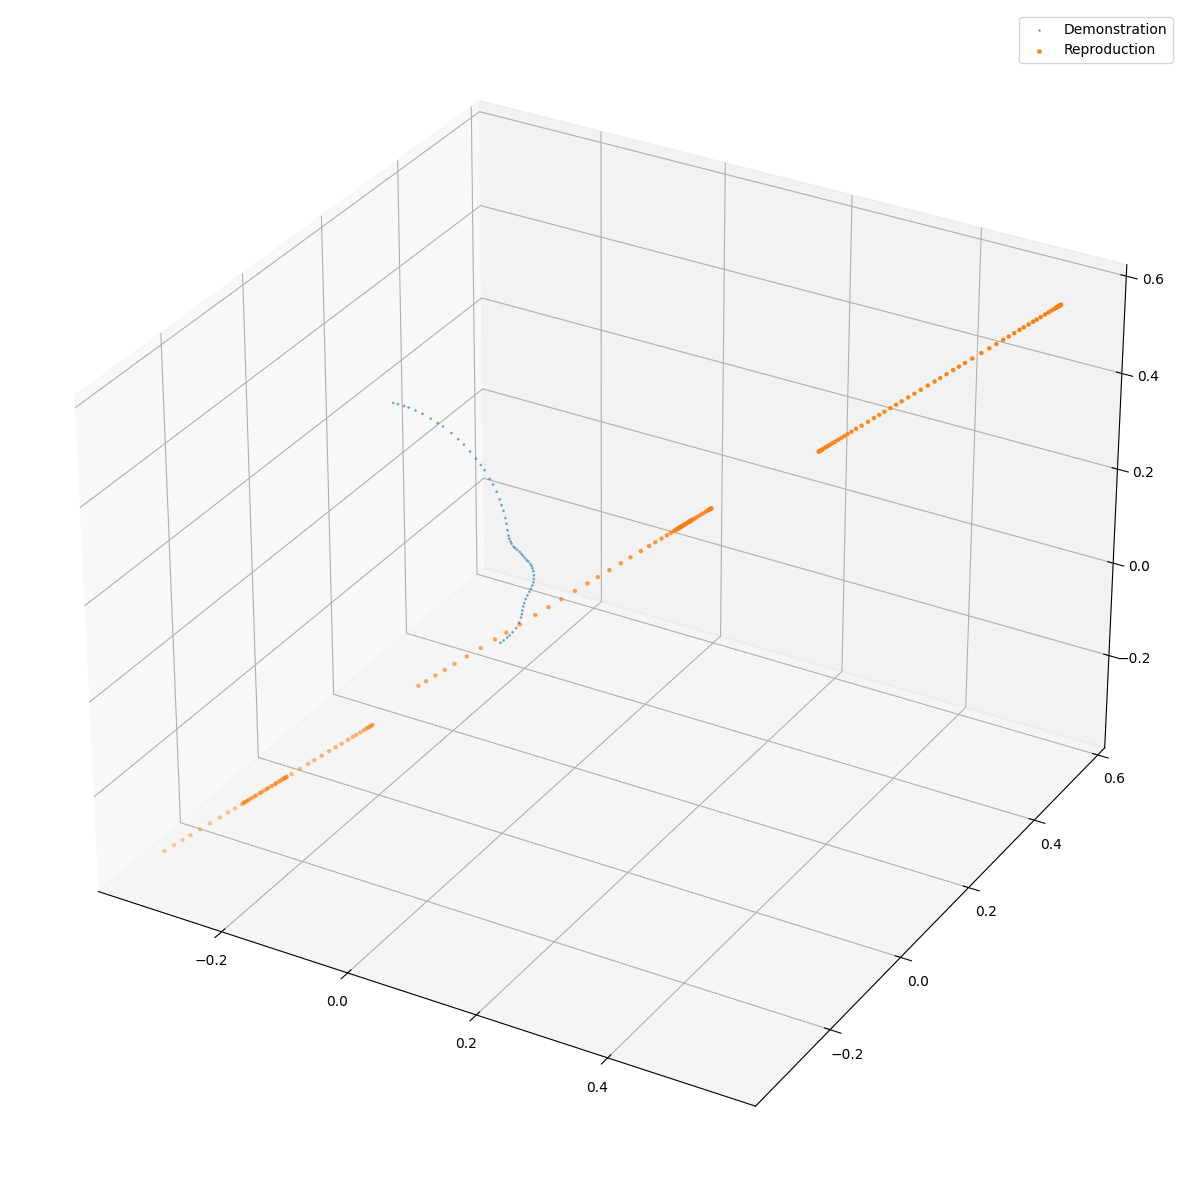

In [144]:
ds_dataset.plot_random()